In [203]:
import pandas as pd

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *
%matplotlib inline

# load data

### transactions

In [204]:
q = '''select
            date_trunc('month', date) as month,
            count(id) as count,
            count(distinct id) as distinct_ids,
            sum(amount) as volume,
            count(distinct(org)) as orgs
        from transactions
        where 
            status='A' and
            date>='2016-09-01'
        group by date_trunc('month', date)'''
trans = redshift_query_read(q, schema='public')

In [205]:
years = [2016, 2017, 2018, 2019, 2020, 2021]
months = [9, 10, 11, 12]
trans['distinct_diff'] = trans['count'] - trans['distinct_ids']

print("check for duplicate transactions")
trans[trans['distinct_diff']!=0]

check for duplicate transactions


,month,count,distinct_ids,volume,orgs,distinct_diff


In [206]:
# drop duplicate check columns
trans.drop(['distinct_diff', 'distinct_ids'], axis=1, inplace=True)

### traffic

In [207]:
q = '''select
            date_trunc('month', date) as month,
            sum(views) as views,
            sum(bounces) as bounces
        from googleanalytics_traffic
        where
            date>='2016-09-01'
        group by date_trunc('month', date)'''
traffic = redshift_query_read(q, schema='public')

### merge

In [208]:
df = trans.merge(traffic, on='month')
df.head(3)

,month,count,volume,orgs,views,bounces
0,2018-07-01,81628,9.827349e+06,1705,1199587,361437
1,2019-06-01,118463,1.336243e+07,1960,2055412,633257
2,2021-02-01,184842,1.177549e+08,2334,2933669,664267


In [209]:
df['month'] = pd.to_datetime(df['month'])
df['views nonbounced'] = df['views'] - df['bounces']
df['bounce rate'] = df['bounces'] / df['views']
df['mean volume'] = df['volume'] / df['count']
df['mean org count'] = df['count'] / df['orgs']
df['mean org volume'] = df['volume'] / df['orgs']

In [210]:
df.head(3)

,month,count,volume,orgs,views,bounces,views nonbounced,bounce rate,mean volume,mean org count,mean org volume
0,2018-07-01,81628,9.827349e+06,1705,1199587,361437,838150,0.301301,120.391890,47.875660,5763.841167
1,2019-06-01,118463,1.336243e+07,1960,2055412,633257,1422155,0.308092,112.798304,60.440306,6817.564005
2,2021-02-01,184842,1.177549e+08,2334,2933669,664267,2269402,0.226429,637.057043,79.195373,50451.970009


# analysis

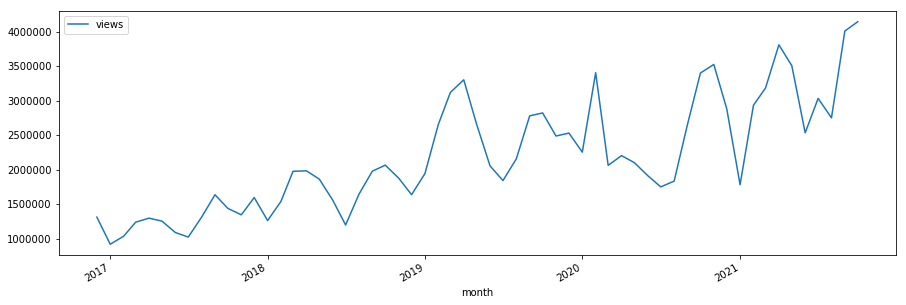

In [211]:
df[['month', 'views']].plot(x='month', figsize=(15,5))

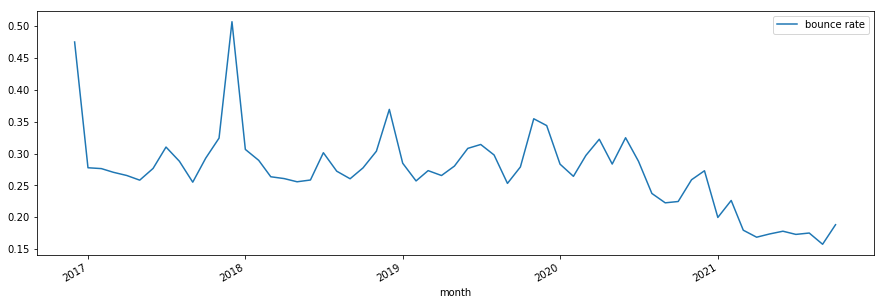

In [212]:
df[['month', 'bounce rate']].plot(x='month', figsize=(15,5))

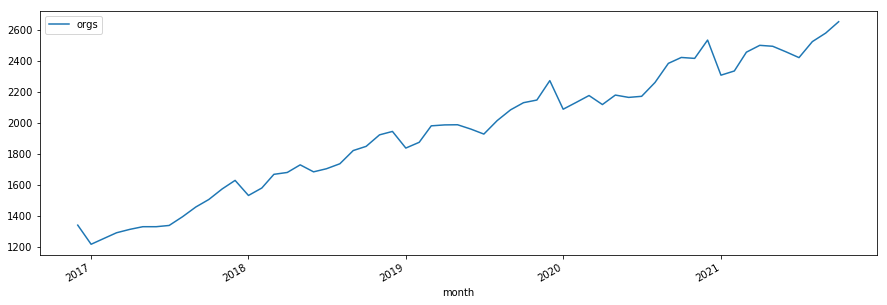

In [213]:
df[['month', 'orgs']].plot(x='month', figsize=(15,5))

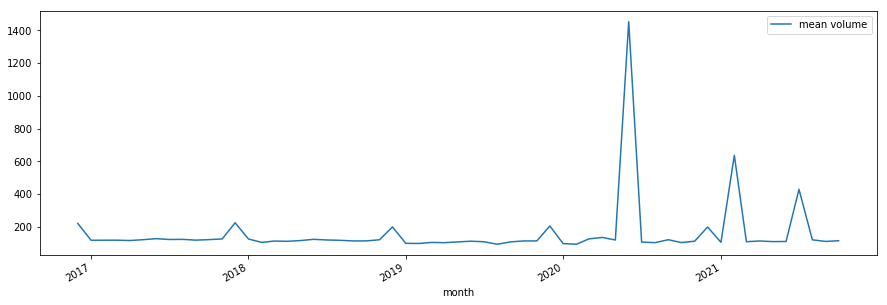

In [214]:
df[['month', 'mean volume']].plot(x='month', figsize=(15,5))

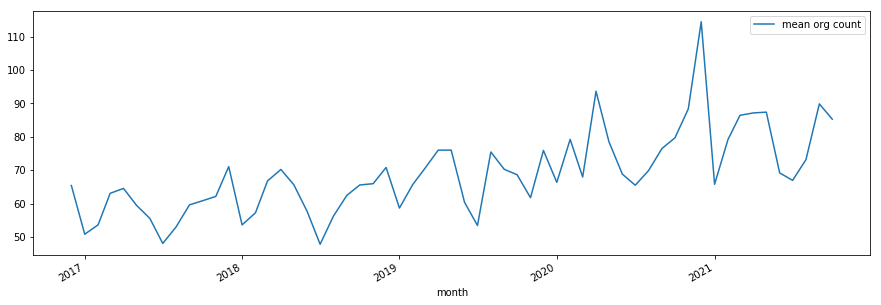

In [215]:
df[['month', 'mean org count']].plot(x='month', figsize=(15,5))

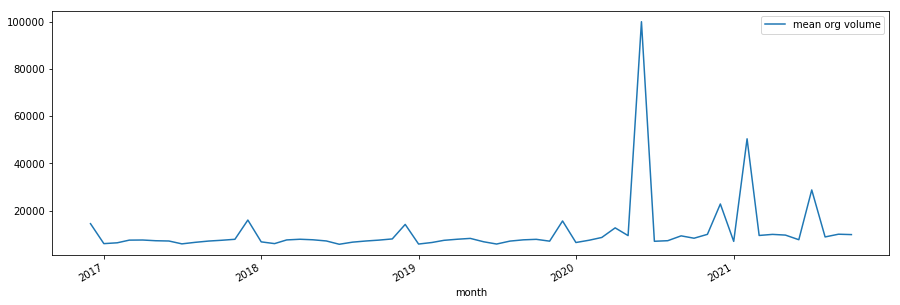

In [216]:
df[['month', 'mean org volume']].plot(x='month', figsize=(15,5))

In [217]:
df = df[df['month'].dt.month.isin([9, 10, 11, 12])].sort_values('month')

In [218]:
non_dt_cols = [c for c in df.columns if c != 'month']

In [219]:
y, m

(2016, 9)

In [220]:
monthly_increases = []
for y in [2016, 2017, 2018, 2019, 2020, 2021]:
    for m in [9, 10, 11, 12]:
        this_data = df[((df['month'].dt.year==y)|(df['month'].dt.year==y - 1))&(df['month'].dt.month==m)]
        if len(this_data) <= 1:
            continue
        this_pct = this_data[non_dt_cols].pct_change().iloc[1]
        this_pct['year'] = y
        this_pct['month'] = m
        monthly_increases.append(this_pct)

In [221]:
monthly = pd.DataFrame(monthly_increases)
monthly['month'] = monthly[['month', 'year']].apply(lambda x: "{}/{}".format(int(x['month']), int(x['year'])), axis=1)
monthly.drop('year', axis=1, inplace=True)
monthly['month'] = pd.to_datetime(monthly['month'])

In [222]:
changes_2021 = monthly[monthly['month'].dt.year==2021]
changes_pre_2021 = monthly[monthly['month'].dt.year!=2021]

In [223]:
past_averages = monthly.groupby(monthly['month'].dt.month).agg({'mean', 'median'})
past_averages.transpose()

month                                     9                    10  \
count            median             0.278531             0.262402   
                 mean               0.277503             0.254782   
volume           median             0.237757              0.22109   
                 mean               0.258549             0.235576   
orgs             median             0.143636             0.144297   
                 mean               0.154476             0.152634   
views            median             0.306764             0.292348   
                 mean               0.269501             0.306168   
bounces          median             0.151395             0.191263   
                 mean               0.127201             0.181555   
views nonbounced median             0.309315             0.329224   
                 mean               0.312072             0.350104   
bounce rate      median            -0.074139            -0.106796   
                 mean              -0.104778            -0.100666   
mean volume      median            -0.046045            -0.032989   
                 mean              -0.013832            -0.011583   
mean org count   median             0.106703             0.074027   
                 mean               0.108835             0.088811   
mean org volume  median             0.071525             0.051926   
                 mean                0.09193             0.074336   
month            median  2020-03-02 00:00:00  2020-04-01 00:00:00   
                 mean    2020-03-02 00:00:00  2020-04-01 00:00:00   

month                                     11                   12  
count            median             0.295869             0.285997  
                 mean               0.316604              0.36025  
volume           median             0.244725             0.315856  
                 mean               0.271132             0.328737  
orgs             median             0.124825             0.180687  
                 mean               0.154087             0.172714  
views            median             0.395029             0.177753  
                 mean               0.378666             0.231466  
bounces          median             0.306737             0.101002  
                 mean               0.295753             0.096937  
views nonbounced median             0.437386             0.287332  
                 mean               0.430532             0.330882  
bounce rate      median            -0.063291            -0.137434  
                 mean              -0.055211            -0.119818  
mean volume      median            -0.039467            -0.006773  
                 mean              -0.037566            -0.024163  
mean org count   median             0.061359             0.079291  
                 mean               0.142577             0.165481  
mean org volume  median             0.019471             0.104472  
                 mean                0.10321             0.138379  
month            median  2019-11-01 00:00:00  2019-06-01 12:00:00  
                 mean    2019-11-01 08:00:00  2019-06-01 18:00:00

In [224]:
past_averages_pre_2021 = changes_pre_2021.groupby(changes_pre_2021['month'].dt.month).agg({'mean', 'median'})
past_averages.transpose()

month                                     9                    10  \
count            median             0.278531             0.262402   
                 mean               0.277503             0.254782   
volume           median             0.237757              0.22109   
                 mean               0.258549             0.235576   
orgs             median             0.143636             0.144297   
                 mean               0.154476             0.152634   
views            median             0.306764             0.292348   
                 mean               0.269501             0.306168   
bounces          median             0.151395             0.191263   
                 mean               0.127201             0.181555   
views nonbounced median             0.309315             0.329224   
                 mean               0.312072             0.350104   
bounce rate      median            -0.074139            -0.106796   
                 mean              -0.104778            -0.100666   
mean volume      median            -0.046045            -0.032989   
                 mean              -0.013832            -0.011583   
mean org count   median             0.106703             0.074027   
                 mean               0.108835             0.088811   
mean org volume  median             0.071525             0.051926   
                 mean                0.09193             0.074336   
month            median  2020-03-02 00:00:00  2020-04-01 00:00:00   
                 mean    2020-03-02 00:00:00  2020-04-01 00:00:00   

month                                     11                   12  
count            median             0.295869             0.285997  
                 mean               0.316604              0.36025  
volume           median             0.244725             0.315856  
                 mean               0.271132             0.328737  
orgs             median             0.124825             0.180687  
                 mean               0.154087             0.172714  
views            median             0.395029             0.177753  
                 mean               0.378666             0.231466  
bounces          median             0.306737             0.101002  
                 mean               0.295753             0.096937  
views nonbounced median             0.437386             0.287332  
                 mean               0.430532             0.330882  
bounce rate      median            -0.063291            -0.137434  
                 mean              -0.055211            -0.119818  
mean volume      median            -0.039467            -0.006773  
                 mean              -0.037566            -0.024163  
mean org count   median             0.061359             0.079291  
                 mean               0.142577             0.165481  
mean org volume  median             0.019471             0.104472  
                 mean                0.10321             0.138379  
month            median  2019-11-01 00:00:00  2019-06-01 12:00:00  
                 mean    2019-11-01 08:00:00  2019-06-01 18:00:00

In [225]:
changes_2021.transpose()

,54,40
count,0.270416,0.171969
volume,0.162613,0.297146
orgs,0.08183,0.095002
views,0.5092,0.218709
bounces,0.068841,0.021467
views nonbounced,0.63537,0.275902
bounce rate,-0.291783,-0.161845
mean volume,-0.084856,0.106809
mean org count,0.174321,0.070289
mean org volume,0.074673,0.184606


# projections

using stats from 10/01/2021 new forms report, past 90 days

In [226]:
new_forms_conversion = 0.0365
new_forms_bounce = 0.2304
new_forms_mean_per_trans = 182.35

old_forms_conversion = 0.0204
old_forms_bounce = 0.1381
old_forms_mean_per_trans = 156.25

### historical YoY averages, no adjustment

- using mean percentage change in count & volume
- using mean percentage change in views to calculate conversion and totals by average transaction amount

In [227]:
count_diff = past_averages['count', 'mean'].reset_index(drop=True)
vol_diff = past_averages['volume', 'mean'].reset_index(drop=True)
views_diff = past_averages['views', 'mean'].reset_index(drop=True)

In [228]:
# simple mean growth
proj_simple = df[df['month'].isin(['2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'])][['count', 'volume', 'month']].reset_index(drop=True)

In [229]:
proj_simple['count 2021 projection'] = proj_simple['count'].reset_index(drop=True) * count_diff
proj_simple['count 2021 projection'] = proj_simple['count 2021 projection'] + proj_simple['count']

proj_simple['volume 2021 projection'] = proj_simple['volume'].reset_index(drop=True) * vol_diff
proj_simple['volume 2021 projection'] = proj_simple['volume 2021 projection'] + proj_simple['volume']

In [230]:
print("| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |")
print("|-----|------|------|-------|-------|")
for _, r in proj_simple.iterrows():
    mkd = "| {:%m} | {:,} | \${:,.2f} | {:,.0f} | \${:,.2f} |"
    print(mkd.format(r['month'], r['count'], r['volume'], r['count 2021 projection'], r['volume 2021 projection']))

| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 233,013 | \$27,970,286.26 |
| 10 | 192,959 | \$20,149,069.04 | 242,121 | \$24,895,704.10 |
| 11 | 213,438 | \$24,070,603.60 | 281,013 | \$30,596,912.65 |
| 12 | 289,960 | \$57,826,789.99 | 394,418 | \$76,836,570.62 |


| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 233,013 | \$27,970,286.26 |
| 10 | 192,959 | \$20,149,069.04 | 218,301 | \$22,051,951.33 |
| 11 | 213,438 | \$24,070,603.60 | 281,013 | \$30,596,912.65 |
| 12 | 289,960 | \$57,826,789.99 | 398,337 | \$76,563,092.27 |

### historical YoY averages, new forms adjusted

adjust the count for the increased conversion, using this increased count to adjust the volume by mean trans value

In [231]:
conv_adjustment = new_forms_conversion - old_forms_conversion
proj_simple['mean trans'] = proj_simple['volume'] / proj_simple['count']

proj_simple['count 2021 projection'] = proj_simple['count 2021 projection'] * (1 + conv_adjustment)
proj_simple['volume 2021 projection'] = proj_simple['mean trans'] * proj_simple['count 2021 projection']

In [232]:
print("| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |")
print("|-----|------|------|-------|-------|")
for _, r in proj_simple.iterrows():
    mkd = "| {:%m} | {:,} | \${:,.2f} | {:,.0f} | \${:,.2f} |"
    print(mkd.format(r['month'], r['count'], r['volume'], r['count 2021 projection'], r['volume 2021 projection']))

| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 236,764 | \$28,848,624.72 |
| 10 | 192,959 | \$20,149,069.04 | 246,020 | \$25,689,736.76 |
| 11 | 213,438 | \$24,070,603.60 | 285,538 | \$32,201,695.92 |
| 12 | 289,960 | \$57,826,789.99 | 400,768 | \$79,925,317.43 |


| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 236,764 | \$28,848,624.72 |
| 10 | 192,959 | \$20,149,069.04 | 221,816 | \$23,162,317.62 |
| 11 | 213,438 | \$24,070,603.60 | 285,538 | \$32,201,695.92 |
| 12 | 289,960 | \$57,826,789.99 | 404,750 | \$80,719,347.85 |

### historical YoY, considering September deviation

In [233]:
# get september percentage deviations from average
deviation_adj_count = (count_diff - changes_2021['count'].iloc[0]) / count_diff
deviation_adj_volume = (vol_diff - changes_2021['volume'].iloc[0]) / vol_diff

In [234]:
proj_simple['count 2021 projection'] = proj_simple['count'].reset_index(drop=True) * count_diff
proj_simple['count 2021 projection'] = proj_simple['count 2021 projection'].reset_index(drop=True) - (proj_simple['count 2021 projection'].reset_index(drop=True) * deviation_adj_count)
proj_simple['count 2021 projection'] = proj_simple['count 2021 projection'] + proj_simple['count']

proj_simple['volume 2021 projection'] = proj_simple['volume'].reset_index(drop=True) * vol_diff
proj_simple['volume 2021 projection'] = proj_simple['volume 2021 projection'].reset_index(drop=True) - (proj_simple['volume 2021 projection'].reset_index(drop=True) * deviation_adj_volume)
proj_simple['volume 2021 projection'] = proj_simple['volume 2021 projection'] + proj_simple['volume']

In [235]:
print("| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |")
print("|-----|------|------|-------|-------|")
for _, r in proj_simple.iterrows():
    mkd = "| {:%m} | {:,} | \${:,.2f} | {:,.0f} | \${:,.2f} |"
    print(mkd.format(r['month'], r['count'], r['volume'], r['count 2021 projection'], r['volume 2021 projection']))

| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 231,720 | \$25,838,187.56 |
| 10 | 192,959 | \$20,149,069.04 | 245,138 | \$23,425,570.36 |
| 11 | 213,438 | \$24,070,603.60 | 271,155 | \$27,984,797.57 |
| 12 | 289,960 | \$57,826,789.99 | 368,370 | \$67,230,179.97 |


| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 231,720 | \$25,838,187.56 |
| 10 | 192,959 | \$20,149,069.04 | 245,138 | \$23,425,570.36 |
| 11 | 213,438 | \$24,070,603.60 | 271,155 | \$27,984,797.57 |
| 12 | 289,960 | \$57,826,789.99 | 368,370 | \$67,230,179.97 |

### historical YoY, new forms considering September deviation

In [236]:
conv_adjustment = new_forms_conversion - old_forms_conversion
proj_simple['mean trans'] = proj_simple['volume'] / proj_simple['count']

proj_simple['count 2021 projection'] = proj_simple['count 2021 projection'] * (1 + conv_adjustment)
proj_simple['volume 2021 projection'] = proj_simple['mean trans'] * proj_simple['count 2021 projection']

In [237]:
print("| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |")
print("|-----|------|------|-------|-------|")
for _, r in proj_simple.iterrows():
    mkd = "| {:%m} | {:,} | \${:,.2f} | {:,.0f} | \${:,.2f} |"
    print(mkd.format(r['month'], r['count'], r['volume'], r['count 2021 projection'], r['volume 2021 projection']))

| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 235,451 | \$28,688,585.64 |
| 10 | 192,959 | \$20,149,069.04 | 249,085 | \$26,009,815.12 |
| 11 | 213,438 | \$24,070,603.60 | 275,521 | \$31,072,003.79 |
| 12 | 289,960 | \$57,826,789.99 | 374,300 | \$74,646,829.28 |


| Month | Count 2020 | Vol 2020 | Count 2021 | Vol 2021 |
|-----|------|------|-------|-------|
| 09 | 182,397 | \$22,224,236.89 | 235,451 | \$28,688,585.64 |
| 10 | 192,959 | \$20,149,069.04 | 249,085 | \$26,009,815.12 |
| 11 | 213,438 | \$24,070,603.60 | 275,521 | \$31,072,003.79 |
| 12 | 289,960 | \$57,826,789.99 | 374,300 | \$74,646,829.28 |

# projections - simple modeling

Want to base projections off a regression rather than 2020 to avoid outliers skewing results

In [238]:
new_forms_conversion = 0.0365
new_forms_bounce = 0.2304

old_forms_conversion = 0.0204
old_forms_bounce = 0.1381

## regression

- traffic = model on org count and bounce rate
- totals = model on org count, traffic, conversion and bounce rate 

In [239]:
from sklearn.linear_model import LinearRegression

In [240]:
df = df[df['month'].dt.year.isin(years)&df['month'].dt.month.isin(months)]

In [241]:
df.tail(3)

,month,count,volume,orgs,views,bounces,views nonbounced,bounce rate,mean volume,mean org count,mean org volume
51,2020-12-01,289960,57826789.99,2533,2884394,787441,2096953,0.273000,199.430232,114.472957,22829.368334
54,2021-09-01,231720,25838187.56,2578,4008918,632305,3376613,0.157725,111.506074,89.883631,10022.570815
40,2021-10-01,226142,26136279.88,2651,4143769,780703,3363066,0.188404,115.574638,85.304413,9859.026737


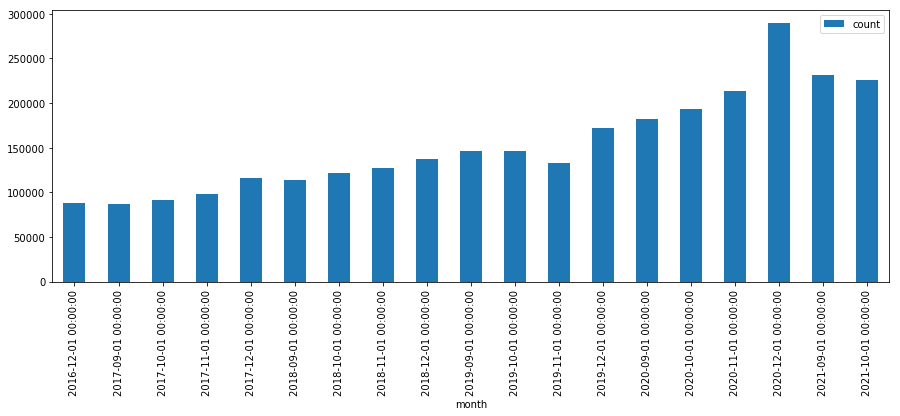

In [242]:
df[['month', 'count']].plot(x='month', y='count', kind='bar', figsize=(15,5))

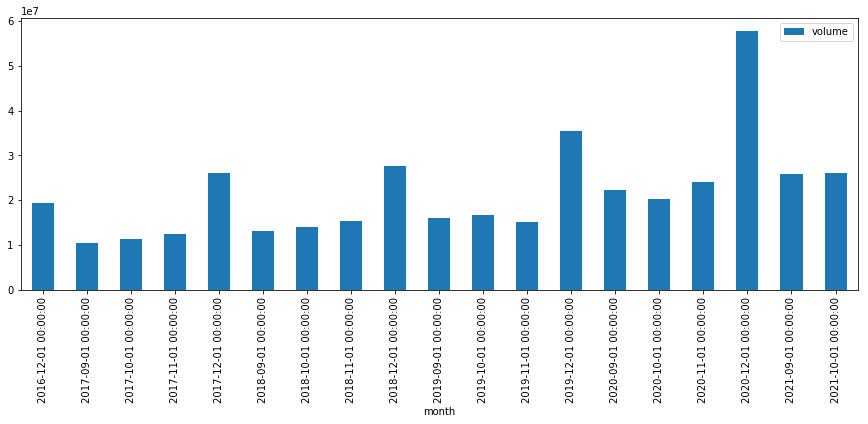

In [243]:
df[['month', 'volume']].plot(x='month', y='volume', kind='bar', figsize=(15,5))

In [244]:
X = df.copy()
X['monthyear'] = X['month']
X['year'] = X['month'].dt.year
X['month'] = X['month'].dt.month

### model count

In [245]:
lr_count = LinearRegression().fit(X[['month', 'year']], df['count'])

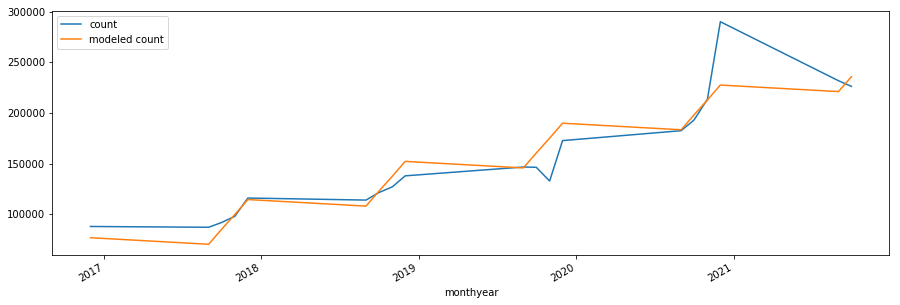

In [246]:
X_test = lr_count.predict(X[['month', 'year']])
X['modeled count'] = X_test
X[['monthyear', 'count', 'modeled count']].plot(y=['count', 'modeled count'], x='monthyear', figsize=(15,5))

In [247]:
X[['monthyear', 'count', 'modeled count']].tail(6)

,monthyear,count,modeled count
58,2020-09-01,182397,183301.607519
53,2020-10-01,192959,198013.648120
50,2020-11-01,213438,212725.688722
51,2020-12-01,289960,227437.729323
54,2021-09-01,231720,220974.941353
40,2021-10-01,226142,235686.981955


### model volume

In [248]:
lr_vol = LinearRegression().fit(X[['month', 'year']], df['volume'])

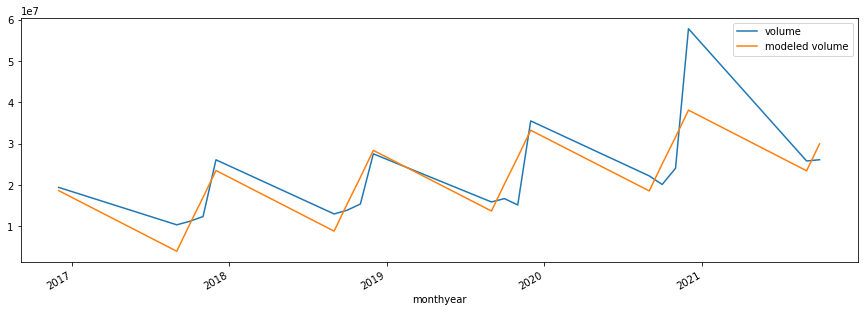

In [249]:
X_test = lr_vol.predict(X[['month', 'year']])
X['modeled volume'] = X_test
X[['monthyear', 'volume', 'modeled volume']].plot(y=['volume', 'modeled volume'], x='monthyear', figsize=(15,5))

In [250]:
X[['monthyear', 'volume', 'modeled volume']].tail(6)

,monthyear,volume,modeled volume
58,2020-09-01,22224236.89,1.859427e+07
53,2020-10-01,20149069.04,2.510738e+07
50,2020-11-01,24070603.60,3.162049e+07
51,2020-12-01,57826789.99,3.813360e+07
54,2021-09-01,25838187.56,2.346047e+07
40,2021-10-01,26136279.88,2.997358e+07


### build projections from modeled values

In [251]:
cols = ['monthyear', 'volume', 'count', 'modeled volume', 'modeled count']
proj = X[cols].iloc[-6:-2].reset_index(drop=True)
proj['count 2021 projection'] = (proj['modeled count'] * count_diff) + proj['modeled count']
proj['volume 2021 projection'] = (proj['modeled volume'] * vol_diff) + proj['modeled volume']

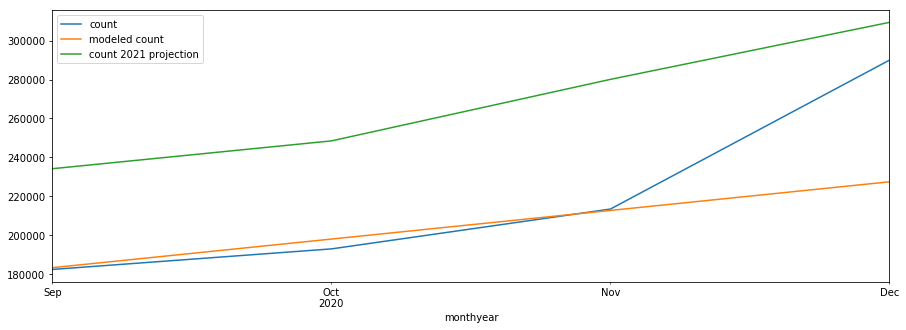

In [252]:
proj[['monthyear', 'count', 'modeled count', 'count 2021 projection']].plot(x='monthyear', figsize=(15,5))

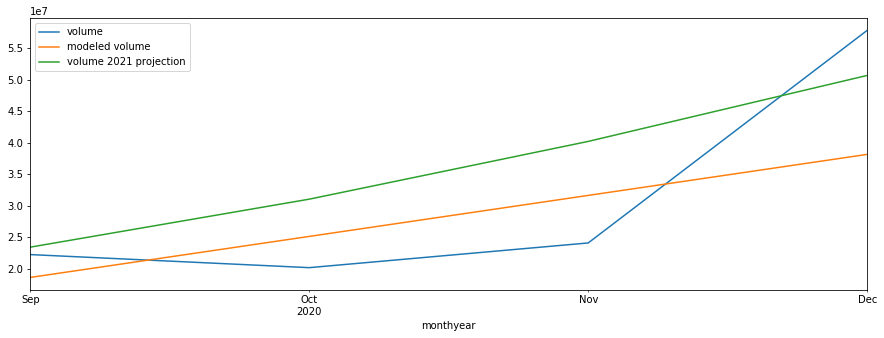

In [253]:
proj[['monthyear', 'volume', 'modeled volume', 'volume 2021 projection']].plot(x='monthyear', figsize=(15,5))

In [254]:
d = proj[['monthyear', 'count 2021 projection', 'volume 2021 projection']]
for _, r in d.iterrows():
    print("{} | {:,.2f} | ${:,.2f}".format(r['monthyear'], r['count 2021 projection'], r['volume 2021 projection']))

2020-09-01 00:00:00 | 234,168.29 | $23,401,798.46
2020-10-01 00:00:00 | 248,463.93 | $31,022,073.87
2020-11-01 00:00:00 | 280,075.58 | $40,193,812.13
2020-12-01 00:00:00 | 309,372.24 | $50,669,504.15


In [256]:
# new forms adjustment
proj['mean trans'] = proj['modeled volume'] / proj['modeled count']

proj['count 2021 projection'] = proj['count 2021 projection'] * (1 + conv_adjustment)
proj['volume 2021 projection'] = proj['mean trans'] * proj['count 2021 projection']

In [257]:
d = proj[['monthyear', 'count 2021 projection', 'volume 2021 projection']]
for _, r in d.iterrows():
    print("{} | {:,.2f} | ${:,.2f}".format(r['monthyear'], r['count 2021 projection'], r['volume 2021 projection']))

2020-09-01 00:00:00 | 237,938.40 | $24,136,674.74
2020-10-01 00:00:00 | 252,464.19 | $32,011,503.20
2020-11-01 00:00:00 | 284,584.80 | $42,301,945.00
2020-12-01 00:00:00 | 314,353.13 | $52,706,363.27
